# Импорт

In [4]:
import sys
sys.path.append('../')
import momepy
import folium
import pyproj
import shapely
import osmnx as ox
import pandas as pd
import networkx as nx
import graphbuilder_v2
import criteria
import geopandas as gpd
from availability_estimation import *

from pprint import pprint
from pyproj import Transformer

# Примеры работы

## Загрузка графа

In [5]:
# В качестве начальных данных подается gpd.GeoDataFrame с Polygon, по которому нужно скачать граф
# lo_polygon = ox.geocode_to_gdf('R176095', by_osmid=True).to_crs(epsg=32636)
# spb_polygon = ox.geocode_to_gdf('R337422', by_osmid=True).to_crs(epsg=32636).buffer(3000)
# city = lo_polygon.union(spb_polygon).to_crs(epsg=4326)
# city = ox.geocode_to_gdf('R1281563', by_osmid=True) # тестовый мини-город, чтобы долго не грузить

# city = ox.geocode_to_gdf('R1572051', by_osmid=True)
mo_polygon = ox.geocode_to_gdf('R51490', by_osmid=True).to_crs(epsg=32636)
m_polygon = ox.geocode_to_gdf('R102269', by_osmid=True).to_crs(epsg=32636).buffer(3000)
city = mo_polygon.union(m_polygon).to_crs(epsg=4326)

graph = graphbuilder_v2.get_graph_from_polygon(city, crs=32636, retain_all=False)

d:\IT\GitHub\transport_frames\.venv\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 52 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [ ]:
# Загрузка локального графа
graph = nx.read_graphml('data/graphml/graph.graphml')
graph = nx.convert_node_labels_to_integers(graph)

In [5]:
# Перевод edges:list -> str
graph = graphbuilder_v2.convert_list_attr_to_str(graph)

In [9]:
nodes, edges = momepy.nx_to_gdf(graph, points=True, lines=True, spatial_weights=False)

In [11]:
edges.to_file("edges.shp")
nodes.to_file("nodes.shp")

C:\Users\local\AppData\Local\Temp\ipykernel_16896\1444497828.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges.to_file("edges.shp")


In [6]:
nx.write_graphml(graph, 'data/graphml/graph_mom.graphml')

## Создание карты по каркасу

In [10]:
import folium
from pyproj import Transformer

# Инициализация трансформера для преобразования из EPSG:32636 в EPSG:4326
transformer = Transformer.from_crs("epsg:32636", "epsg:4326")

# Выделение дорог с федеральным/региональным статусом
e = [(u, v, k, d) for u, v, k, d in graph.edges(data=True, keys=True) if d.get('reg') in ([1, 2])]

m = folium.Map(tiles='CartoDB Dark_Matter')

# Создание FeatureGroup для слоев
lines_reg1_layer = folium.FeatureGroup(name='Lines Reg1', show=False)
lines_reg2_layer = folium.FeatureGroup(name='Lines Reg2', show=False)
nodes_layer = folium.FeatureGroup(name='Nodes', show=False)
exit_nodes_layer = folium.FeatureGroup(name='Exit Nodes', show=False)

# Преобразование и отображение узлов и линий
for u, v, k, d in e:
    start_y, start_x = graph.nodes[u]['y'], graph.nodes[u]['x']
    end_y, end_x = graph.nodes[v]['y'], graph.nodes[v]['x']
    
    # Преобразование координат
    start_lat, start_lon = transformer.transform(start_x, start_y)
    end_lat, end_lon = transformer.transform(end_x, end_y)
    
    # Создание линии
    line_coords = [
        [start_lat, start_lon],
        [end_lat, end_lon]
    ]
    
    if d.get('reg') == 1:
        folium.PolyLine(locations=line_coords, color='#AAFF01').add_to(lines_reg1_layer)
    elif d.get('reg') == 2:
        folium.PolyLine(locations=line_coords, color='#00AAFF').add_to(lines_reg2_layer)
    
    # Условие для цвета CircleMarker и создание tooltip
    start_color = '#FE4F19' if graph.nodes[u].get('exit') == 1 else '#13D1FF'
    end_color =   '#FE4F19' if graph.nodes[v].get('exit') == 1 else '#13D1FF'
    
    start_tooltip = f"Exit: {graph.nodes[u].get('exit')}, Reg1: {graph.nodes[u].get('reg_1')}, Reg2: {graph.nodes[u].get('reg_2')}"
    end_tooltip =   f"Exit: {graph.nodes[v].get('exit')}, Reg1: {graph.nodes[v].get('reg_1')}, Reg2: {graph.nodes[v].get('reg_2')}"
    
    # Добавление CircleMarker для начального узла
    folium.CircleMarker(
        location=[start_lat, start_lon],
        radius=2,
        color=start_color,
        fill=True,
        opacity=1,
        fill_color=start_color,
        tooltip=start_tooltip
    ).add_to(exit_nodes_layer if graph.nodes[u].get('exit') == 1 else nodes_layer)
    
    # Добавление CircleMarker для конечного узла
    folium.CircleMarker(
        location=[end_lat, end_lon],
        radius=2,
        color=end_color,
        fill=True,
        opacity=1,
        fill_color=end_color,
        tooltip=end_tooltip
    ).add_to(exit_nodes_layer if graph.nodes[v].get('exit') == 1 else nodes_layer)

# Добавление слоев на карту
lines_reg1_layer.add_to(m)
lines_reg2_layer.add_to(m)
nodes_layer.add_to(m)
exit_nodes_layer.add_to(m)

# Отображение границы полигона (например, города)
city.boundary.explore(m=m, color='#AA00FF', name='Cities', opacity=0.8, show=False)

# Добавление контроля слоев
folium.LayerControl().add_to(m)

# Сохранение карты
m.save('data/html/mom_graphbuilder2.html')


## Перевод graph -> GeoDataFrame

### Конвертация str -> geometry

In [11]:
# Конвертация str -> geometry
graph = graphbuilder_v2.convert_geometry_from_wkt(graph)

05-30 14:08 | INFO     | Starting the conversion of the graph.
05-30 14:09 | INFO     | The graph was converted!


In [ ]:
# Преобразуем граф в GeoDataFrames
nodes, edges = momepy.nx_to_gdf(graph, points=True, lines=True, spatial_weights=False)

## Вывод на карту определенный тип reg_status дороги

In [ ]:
# Разница между предыдущим и этим методом:
# Вариант выше рисовал узлы и ребра графа. Этот вариант рисует геометрию

edges = edges.to_crs(epsg=4326)
edges_filtered = edges[edges['reg'].isin([1, 2])]

m = folium.Map()

# Определение цветов для разных значений reg
color_map = {1: 'red', 2: 'blue', 3: 'green'}

# Добавление рёбер на карту
for _, row in edges_filtered.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, color=color_map[row['reg']]: {'color': color},
        tooltip=f"highway: {row['highway']}, ref: {row['ref']}, reg: {row['reg']}"
    ).add_to(m)

# Отображение карты
m.save('../data/html/roads.html')

## Проецирование точек на узлы графа

In [ ]:
# Пример проецирования точек на граф. Важно: пример для Ленинградской области и Санкт-Петербурга

lomonosov = ox.geocode_to_gdf('N411691832', by_osmid=True).to_crs(epsg=32636)[['geometry','name']]
lomonosov.loc[0, 'name'] = 'Ломоносов'

city_points = gpd.read_file('../data/geojsons/СНП ЛО.geojson')
rr_points = gpd.read_file('../data/geojsons/ЖД остановки.geojson').to_crs(epsg=32636)

cities = ["приозерск", "кировск", "кингисепп", "луга", 
          "лодейное поле", "гатчина", "тихвин", "тосно", 
          "выборг", "бокситогорск", "всеволожск", "волосово", 
          "волхов", "сосновый бор", "сланцы", "подпорожье", "кириши"]

# Выделение административных центров
city_points = city_points[
    (city_points['name'].str.lower().isin(cities)) &
    (city_points['rural settlement'].str.contains('административный центр'))
].sort_values('name')

city_points = city_points.to_crs(epsg=32636)
city_points = pd.concat([city_points, lomonosov]).reset_index(drop=True)

nodes_fil = nodes[(nodes['reg_1'] == True) | (nodes['reg_2'] == True)]
graph = graphbuilder_v2.assign_city_names_to_nodes(city_points, nodes_fil, graph, name_attr='city_name', node_id_attr='nodeID', name_col='name', max_distance=1200)
graph = graphbuilder_v2.assign_city_names_to_nodes(rr_points, nodes_fil, graph, name_attr='rr_name', node_id_attr='nodeID', name_col='NAME', max_distance=1200)

In [ ]:
import folium
from pyproj import Transformer

# Инициализация трансформера для преобразования из EPSG:32636 в EPSG:4326
transformer = Transformer.from_crs("epsg:32636", "epsg:4326")

# Инициализация карты
m = folium.Map(tiles='CartoDB Dark_Matter')

# Создание FeatureGroup для слоев
nodes_city_layer = folium.FeatureGroup(name='Nodes with City Names', show=False)
nodes_rr_layer = folium.FeatureGroup(name='Nodes with RR Names', show=False)
nodes_default_layer = folium.FeatureGroup(name='Other Nodes', show=False)
lines_layer_reg1 = folium.FeatureGroup(name='Lines reg 1', show=False)
lines_layer_reg2 = folium.FeatureGroup(name='Lines reg 2', show=False)
exit_nodes_layer = folium.FeatureGroup(name='Exit Nodes', show=False)

# Преобразование и отображение узлов и линий
for u, v, k, d in graph.edges(data=True, keys=True):
    start_y, start_x = graph.nodes[u]['y'], graph.nodes[u]['x']
    end_y, end_x = graph.nodes[v]['y'], graph.nodes[v]['x']
    
    # Преобразование координат
    start_lat, start_lon = transformer.transform(start_x, start_y)
    end_lat, end_lon = transformer.transform(end_x, end_y)
    
    # Создание линии
    line_coords = [
        [start_lat, start_lon],
        [end_lat, end_lon]
    ]
    
    if d.get('reg') == 1:
        folium.PolyLine(locations=line_coords, color='blue').add_to(lines_layer_reg1)
    elif d.get('reg') == 2:
        folium.PolyLine(locations=line_coords, color='green').add_to(lines_layer_reg2)
    
    # Проверка и добавление узлов
    for node, lat, lon in [(u, start_lat, start_lon), (v, end_lat, end_lon)]:
        if graph.nodes[node].get('exit') == 1:
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color='#FE4F19',
                fill=True,
                fill_color='#FE4F19',
                tooltip=f"Exit: {graph.nodes[node].get('exit')}, Reg1: {graph.nodes[node].get('reg_1')}, Reg2: {graph.nodes[node].get('reg_2')}"
            ).add_to(exit_nodes_layer)
        elif graph.nodes[node].get('city_name'):
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color='red',
                fill=True,
                fill_color='red',
                tooltip=str(graph.nodes[node]['city_name'])
            ).add_to(nodes_city_layer)
        elif graph.nodes[node].get('rr_name'):
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color='yellow',
                fill=True,
                fill_color='yellow',
                tooltip=str(graph.nodes[node]['rr_name'])
            ).add_to(nodes_rr_layer)
        elif graph.nodes[node].get('reg_1') == True or graph.nodes[node].get('reg_2'):
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color='gray',
                fill=True,
                fill_color='gray'
            ).add_to(nodes_default_layer)

# Добавление слоев на карту
nodes_rr_layer.add_to(m)
lines_layer_reg1.add_to(m)
lines_layer_reg2.add_to(m)
exit_nodes_layer.add_to(m)
nodes_city_layer.add_to(m)
nodes_default_layer.add_to(m)

# Добавление контроля слоев
folium.LayerControl().add_to(m)

# Сохранение карты
m.save('../data/html/LO_all_data.html')

## Выделение подграфа (каркаса)

In [ ]:
e = [(u, v, k) for u, v, k, d in graph.edges(data=True, keys=True) if d.get('reg') in([1, 2])]
subgraph = graph.edge_subgraph(e).copy()

## Assessment of the state of the territory

In [14]:


# inter = nx.read_graphml('data/graphml/inter.graphml')
# inter = prepare_graph(inter)

# city_points = gpd.read_file("data/geojson/admin_centers_LO_188_points.geojson")
polygons188 = gpd.read_file("data/geojson/polygons188.geojson")
points = gpd.read_file("data/geojson/points.geojson")

p1 = gpd.read_file('data/geojson/Аэродром лодейнопольское поселение.geojson')
p2 = gpd.read_file('data/geojson/Аэродром Сиверск .geojson')
p3 = gpd.read_file('data/geojson/project Светогорского поселения.geojson')
p4 = gpd.read_file('data/geojson/project Шлиссельбург.geojson')

ferry = gpd.read_file('data/geojson/water_transport_LO.geojson')
aero = gpd.read_file('data/geojson/airports_local_LO.geojson')
r_stops = gpd.read_file('data/geojson/ЖД остановки.geojson')
fuel = gpd.read_file('data/geojson/fuel.geojson')
b_stops = gpd.read_file('data/geojson/Остановки ЛО.geojson')

# Загрузка локального графа
graph = nx.read_graphml('data/graphml/graph.graphml')
# Перевод nodes:str -> int, geometry:str -> geometry
graph = nx.convert_node_labels_to_integers(graph)
graph = graphbuilder_v2.convert_geometry_from_wkt(graph)
# Перевод edges:str -> list
graph = graphbuilder_v2.convert_list_attr_from_str(graph)

05-27 14:12 | INFO     | Starting the conversion of the graph.
05-27 14:13 | INFO     | The graph was converted!


In [ ]:
adj_mx = availability_matrix(graph,points)
p = find_median(points,adj_mx)

In [ ]:
p_agg = p[p['to_service'] < np.finfo(np.float64).max].copy()
res = gpd.sjoin(p_agg, polygons188, how='left', op='within').groupby('index_right').median(['to_service']).reset_index()
result_df = pd.merge(polygons188.reset_index(), res, left_on='index', right_on='index_right', how='left').drop(columns=['fid_right']).rename(columns={'to_service': 'in_car'})
result_df = result_df.drop(columns=['index_right'])

In [ ]:
inter = nx.convert_node_labels_to_integers(inter)
adj_mx_inter = availability_matrix(inter,points,graph_type=[GraphType.PUBLIC_TRANSPORT, GraphType.WALK])
p_inter = find_median(points,adj_mx_inter)
points_inter = p_inter[p_inter['to_service'] < np.finfo(np.float64).max].copy()


In [ ]:
res_inter = gpd.sjoin(points_inter, polygons188, how="left", predicate="within").groupby('index_right').median(['to_service']).reset_index()
result_df_inter = pd.merge(result_df, res_inter, left_on='index', right_on='index_right', how='left').drop(columns=['index_right', 'fid_right']).rename(columns={'to_service': 'in_inter'})

In [ ]:
neudobiya = pd.concat([p1,p2,p3,p4])
n_grade = grade_territory(neudobiya, graph, r_stops)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx

# Grade the territories
graded_gdf = criteria.weight_territory(n_grade, r_stops, b_stops, ferry, aero)
graded_gdf


In [ ]:
result = criteria.assign_grades(graded_gdf[['name', 'geometry', 'grade', 'weight']], result_df_inter[['index', 'fid', 'name', 'geometry', 'in_car', 'in_inter']])

result.to_file('data/geojson/result_assesment.geojson', driver='GeoJSON')

In [ ]:
import geopandas as gpd
import folium
from folium import CircleMarker
from shapely.geometry import Polygon
from pyproj import Transformer
import osmnx as ox

# Инициализация трансформера для преобразования из EPSG:32636 в EPSG:4326
transformer = Transformer.from_crs("epsg:32636", "epsg:4326")

# Преобразование CRS и добавление буферной зоны к полигонам
result = result.to_crs(epsg=32636)
buffered_result = result.copy()
buffered_result['geometry'] = buffered_result['geometry'].buffer(15000)
result = result.to_crs(epsg=4326)  # Возвращаем обратно в WGS 84 для отображения в Folium
buffered_result = buffered_result.to_crs(epsg=4326)

# Функция для добавления CircleMarker в группу слоев
def add_circle_markers(gdf, map_obj, color):
    for idx, row in gdf.iterrows():
        try:
            lat = row.geometry.y
            lon = row.geometry.x
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
            ).add_to(map_obj)
        except AttributeError as e:
            print(f"Ошибка на индексе {idx}: {e}")
        except Exception as e:
            print(f"Неизвестная ошибка на индексе {idx}: {e}")

# Создание карты Folium
m = folium.Map(location=[60, 30], zoom_start=6, tiles=None)

# Преобразование и отображение узлов и линий
# Разделение ребер на два списка по значению reg
edges_reg_1 = [(u, v, k) for u, v, k, d in graph.edges(data=True, keys=True) if d.get('reg') == 1]
edges_reg_2 = [(u, v, k) for u, v, k, d in graph.edges(data=True, keys=True) if d.get('reg') == 2]

# Создание групп слоев
lines_reg_1_layer = folium.FeatureGroup(name='Lines Reg 1', show=False)
lines_reg_2_layer = folium.FeatureGroup(name='Lines Reg 2', show=False)
nodes_layer = folium.FeatureGroup(name='Nodes', show=False)
exit_nodes_layer = folium.FeatureGroup(name='Exit Nodes', show=False)

# Функция для добавления ребер в слой
def add_edges_to_layer(edges, layer, color):
    for u, v, k in edges:
        start_y, start_x = graph.nodes[u]['y'], graph.nodes[u]['x']
        end_y, end_x = graph.nodes[v]['y'], graph.nodes[v]['x']
        
        # Преобразование координат
        start_lat, start_lon = transformer.transform(start_x, start_y)
        end_lat, end_lon = transformer.transform(end_x, end_y)
        
        # Создание линии
        line_coords = [
            [start_lat, start_lon],
            [end_lat, end_lon]
        ]
        folium.PolyLine(locations=line_coords, color=color).add_to(layer)
        
        # Условие для цвета CircleMarker и создание tooltip
        start_color = '#FE4F19' if graph.nodes[u].get('exit') == 1 else '#13D1FF'
        end_color =   '#FE4F19' if graph.nodes[v].get('exit') == 1 else '#13D1FF'
        
        start_tooltip = f"Exit: {graph.nodes[u].get('exit')}, Reg1: {graph.nodes[u].get('reg_1')}, Reg2: {graph.nodes[u].get('reg_2')}"
        end_tooltip =   f"Exit: {graph.nodes[v].get('exit')}, Reg1: {graph.nodes[v].get('reg_1')}, Reg2: {graph.nodes[v].get('reg_2')}"
        
        # Добавление CircleMarker для начального узла
        folium.CircleMarker(
            location=[start_lat, start_lon],
            radius=2,
            color=start_color,
            fill=True,
            opacity=1,
            fill_color=start_color,
            tooltip=start_tooltip
        ).add_to(exit_nodes_layer if graph.nodes[u].get('exit') == 1 else nodes_layer)
        
        # Добавление CircleMarker для конечного узла
        folium.CircleMarker(
            location=[end_lat, end_lon],
            radius=2,
            color=end_color,
            fill=True,
            opacity=1,
            fill_color=end_color,
            tooltip=end_tooltip
        ).add_to(exit_nodes_layer if graph.nodes[v].get('exit') == 1 else nodes_layer)

# Добавление ребер в соответствующие слои
add_edges_to_layer(edges_reg_1, lines_reg_1_layer, color='#AAFF01')
add_edges_to_layer(edges_reg_2, lines_reg_2_layer, color='#FF01AA')

# Добавление слоев на карту
lines_reg_1_layer.add_to(m)
lines_reg_2_layer.add_to(m)
nodes_layer.add_to(m)
exit_nodes_layer.add_to(m)

# Добавление границы полигона (например, города)
city.boundary.explore(m=m, color='#AA00FF', name='Cities', opacity=0.8, show=False)

# Добавление базовых карт
folium.TileLayer('OpenStreetMap', name='Light Map').add_to(m)
folium.TileLayer('cartodbdark_matter', name='Dark Map').add_to(m)

# Создание групп слоев
ferry_group = folium.FeatureGroup(name='Ferry', show=False).add_to(m)
aero_group = folium.FeatureGroup(name='Airports', show=False).add_to(m)
r_stops_group = folium.FeatureGroup(name='Rail stops', show=False).add_to(m)
b_stops_group = folium.FeatureGroup(name='Bus stops', show=False).add_to(m)
result_group = folium.FeatureGroup(name='Result Polygons', show=False).add_to(m)
buffer_group = folium.FeatureGroup(name='Buffer Polygons', show=False).add_to(m)

# Добавление CircleMarkers в соответствующие группы
add_circle_markers(ferry, ferry_group, 'blue')
add_circle_markers(aero, aero_group, 'red')
add_circle_markers(r_stops, r_stops_group, 'green')
add_circle_markers(b_stops, b_stops_group, '#DEAC80')

# Добавление полигонов и буферной зоны в соответствующие группы с tooltip
folium.GeoJson(result, color='#B5C18E').add_to(result_group)
folium.GeoJson(buffered_result, color='#F7DCB9').add_to(buffer_group)

# Добавление контроля слоев
folium.LayerControl().add_to(m)

legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 150px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.8;">
     &nbsp; <b>Legend</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i> Ferry <br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i> Airports <br>
     &nbsp; <i class="fa fa-circle" style="color:green"></i> Railway stops <br>
     &nbsp; <i class="fa fa-circle" style="color:#DEAC80"></i> Bus stops <br>
     &nbsp; <i class="fa fa-square" style="color:#B5C18E"></i> Result Polygons <br>
     &nbsp; <i class="fa fa-square" style="color:#F7DCB9"></i> Buffer Polygons <br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
# Сохранение карты в файл
m.save('data/html/map.html')

m

## Доступность для 4 полигонов

In [69]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

def visualize_availability(points, polygons, service_gdf=None, median=True, title='Доступность сервиса, мин'):
    """
    Visualize the service availability on a map with bounding polygons.
    Optionally service points and city points are shown.

    Parameters:
    points (geopandas.GeoDataFrame): GeoDataFrame of points with 'to_service' column.
    polygons (geopandas.GeoDataFrame): GeoDataFrame of polygons.
    service_gdf (geopandas.GeoDataFrame, optional): GeoDataFrame of service points. Defaults to None.
    median (bool, optional): Whether to aggregate time by median among cities in the polygon. Defaults to True.
    title (str, optional): Title of the plot. Defaults to 'Доступность сервиса, мин'.
    """
    # Преобразование координатных систем
    points = points.to_crs(polygons.crs)
    polygons = polygons.to_crs(epsg=3857)
    points = points.to_crs(epsg=3857)
    if service_gdf is not None:
        service_gdf = service_gdf.to_crs(epsg=3857)
    
    vmax = points['to_service'].max()
    res = gpd.sjoin(points, polygons, how="left", predicate="within").groupby('index_right').median(['to_service'])
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # Визуализация границ полигонов
    polygons.boundary.plot(ax=ax, color='black', linewidth=1)

    if not median:
        merged = points
        merged.plot(column='to_service', cmap='RdYlGn_r', ax=ax, legend=True, vmax=vmax, markersize=4)
    else:
        merged = pd.merge(polygons.reset_index(), res, left_on='index', right_on='index_right')
        merged.plot(column='to_service', cmap='RdYlGn_r', ax=ax, legend=True, vmax=vmax, markersize=4)
    
    if service_gdf is not None:
        service_gdf.plot(ax=ax, markersize=30, color='gray', alpha=0.6)

    # Добавление аннотаций для значений 'to_service'
    for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['to_service']):
        ax.annotate(round(label, 1), xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=9, color='black', weight='bold')

    # Добавление подложки карт из contextily
    ctx.add_basemap(ax, crs=polygons.crs.to_string())

    plt.title(title)
    plt.axis('off')
    plt.savefig(f'data/png/{title}.png', dpi=300)
    plt.show()


In [ ]:
neudobiya = pd.concat([p1,p2,p3,p4]).reset_index(drop=True)
neudobiya_polygon = pd.concat([p1,p2,p3,p4]).reset_index(drop=True)
neudobiya['geometry'] = neudobiya['geometry'].centroid
visualize_availability(find_nearest(neudobiya, availability_matrix(graph, neudobiya, r_stops)),neudobiya_polygon,title='Доступность ЖД остановок, мин',service_gdf=r_stops)
visualize_availability(find_nearest(neudobiya, availability_matrix(graph, neudobiya, fuel)),neudobiya_polygon,title='Доступность АЗС, мин',service_gdf=fuel)
visualize_availability(find_nearest(neudobiya, availability_matrix(graph, neudobiya, ferry)),neudobiya_polygon,title='Доступность объектов водного траснпорта, мин',service_gdf=ferry)
visualize_availability(find_nearest(neudobiya, availability_matrix(graph, neudobiya, aero)),neudobiya_polygon,title='Доступность аэропортов, мин',service_gdf=aero)

In [ ]:
pulkovo = gpd.read_file('data/geojson/pulkovo.geojson')
pulkovo = pulkovo.head(1)
pulkovo['geometry'] = pulkovo['geometry'].centroid
pulkovo_polygon = gpd.read_file('data/geojson/pulkovo.geojson')
pulkovo_polygon = pulkovo_polygon.head(1)
visualize_availability(find_nearest(neudobiya, availability_matrix(graph, neudobiya, pulkovo)),neudobiya_polygon,title='Доступность международных аэропортов, мин',service_gdf=pulkovo)

In [ ]:
gatchina = points[points['name'] == 'Гатчина']
p['to_service'] = find_nearest(neudobiya, availability_matrix(graph, neudobiya, gatchina, weight='length_meter'))['to_service'] / 1000
visualize_availability(p,neudobiya_polygon,title='Удаленность до столицы области, км',service_gdf=gatchina)

In [111]:
admin_centers = gpd.read_file('data/geojson/admin_centers_LO_188_points.geojson')

In [117]:
# Преобразование координатных систем для обеспечения совместимости
polygons188 = polygons188.to_crs(epsg=3857)
neudobiya_polygon = neudobiya_polygon.to_crs(epsg=3857)
points = points.to_crs(epsg=3857)
admin_centers = admin_centers.to_crs(epsg=3857)

# Шаг 1: Пространственное объединение для определения пересекающихся полигонов
intersected_polygons = gpd.sjoin(polygons188, neudobiya_polygon, how='inner', predicate='intersects')

# Шаг 2: Определение уникальных полигонов из polygons188, которые пересекаются с neudobiya_polygon
unique_polygons = polygons188[polygons188.index.isin(intersected_polygons.index)]

# Шаг 3: Пространственное объединение для выделения точек, находящихся внутри полигонов из unique_polygons
points_in_polygons = gpd.sjoin(points, unique_polygons, how='inner', predicate='within')

# Шаг 4: Пространственное объединение для выделения точек из admin_centers, находящихся внутри полигонов из unique_polygons
admin_centers_in_polygons = gpd.sjoin(admin_centers, unique_polygons, how='inner', predicate='within')

# Теперь unique_polygons содержит полигоны из polygons188, которые пересекаются с neudobiya_polygon
# points_in_polygons содержит точки, находящиеся внутри этих полигонов
# admin_centers_in_polygons содержит точки из admin_centers, находящиеся внутри этих полигонов

# Вы можете визуализировать результаты
# base = unique_polygons.explore(color='blue', style_kwds={'fillOpacity': 0.2})
# points_in_polygons.explore(m=base, color='red')
# admin_centers_in_polygons.explore(m=base, color='green')


05-27 18:02 | INFO     | Creating adjacency matrix based on provided graph...
05-27 18:03 | INFO     | Adjacency matrix done!


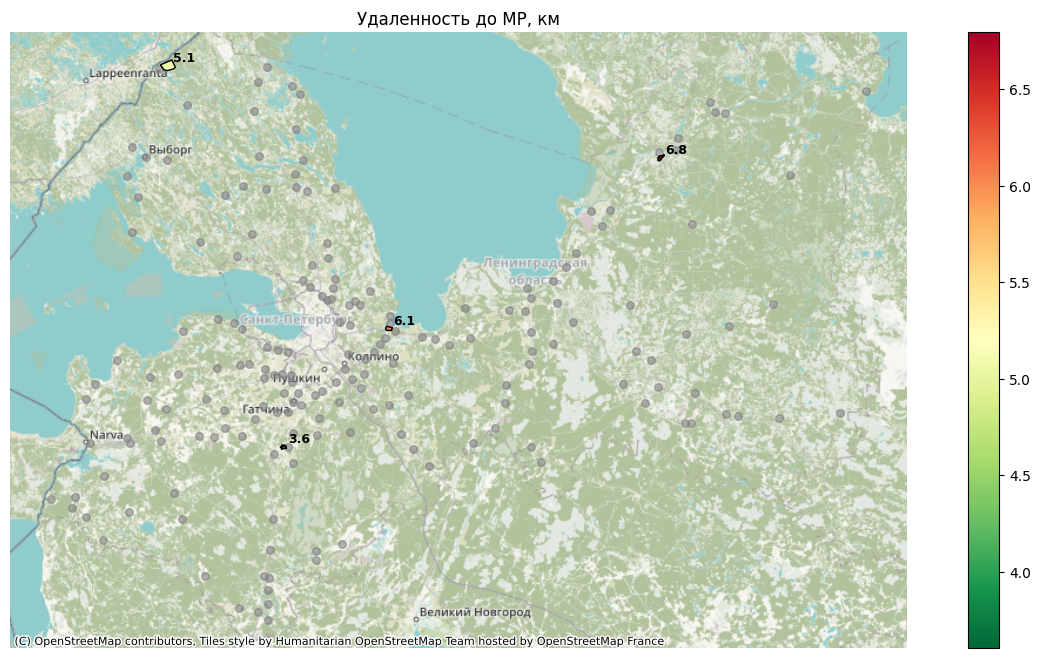

In [161]:
# admin_centers = admin_centers.drop(columns='index_right')
p['to_service'] = find_nearest(neudobiya, availability_matrix(graph, neudobiya, admin_centers, weight='length_meter'))['to_service'] / 1000
visualize_availability(p,neudobiya_polygon,title='Удаленность до МР, км',service_gdf=admin_centers)

In [ ]:
points_in_polygons = points_in_polygons.drop(columns='index_right')
p['to_service'] = find_nearest(neudobiya, availability_matrix(graph, neudobiya, admin_centers, weight='length_meter'))['to_service'] / 1000
visualize_availability(p,neudobiya_polygon,title='Удаленность до ближайших НП, км',service_gdf=points_in_polygons)

In [159]:
def visualize_map(polygon, points, availability, filename):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    polygon.boundary.plot(ax=ax, color='black', linewidth=2)
    points.plot(ax=ax, markersize=50, color='red')

    # Добавление значений около точек
    for x, y, label in zip(points.geometry.x, points.geometry.y, availability):
        ax.annotate(f'{label:.2f}', xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=9, color='black', weight='bold')

    # Добавление подложки карт из contextily
    ctx.add_basemap(ax, crs=polygon.crs.to_string())

    plt.title('Удаленность до МР, км')
    plt.axis('off')
    plt.savefig(filename)
    plt.close()

# Преобразование координатных систем для обеспечения совместимости
polygons188 = polygons188.to_crs(epsg=32636)
neudobiya_polygon = neudobiya_polygon.to_crs(epsg=32636)
admin_centers = admin_centers.to_crs(epsg=32636)

# Шаг 1: Пространственное объединение для определения пересекающихся полигонов
intersected_polygons = gpd.sjoin(polygons188, neudobiya_polygon, how='inner', predicate='intersects')

# Шаг 2: Определение уникальных полигонов из polygons1, которые пересекаются с polygons2
unique_polygons = polygons188[polygons188.index.isin(intersected_polygons.index)]

# Шаг 3: Пространственное объединение для выделения точек, находящихся внутри полигонов из unique_polygons
points_in_polygons = gpd.sjoin(admin_centers, unique_polygons, how='inner', predicate='within')

# Шаг 4: Обработка точек, которые оказались в пересекающихся полигонах и рисование карты
for idx, row in neudobiya_polygon.iterrows():
    sub_polygons = unique_polygons[unique_polygons.intersects(row.geometry)]
    sub_points = points_in_polygons[points_in_polygons.within(sub_polygons.unary_union)].drop(columns='index_right')
    
    availability = availability_matrix(graph, neudobiya.iloc[[idx]], sub_points, weight='length_meter')
    visualize_map(neudobiya_polygon.iloc[[idx]], sub_points, availability, f'Удаленность до МР {idx+1}, км.png')

05-27 17:54 | INFO     | Creating adjacency matrix based on provided graph...


05-27 17:54 | INFO     | Adjacency matrix done!
05-27 17:54 | INFO     | Creating adjacency matrix based on provided graph...
05-27 17:55 | INFO     | Adjacency matrix done!
05-27 17:55 | INFO     | Creating adjacency matrix based on provided graph...
05-27 17:55 | INFO     | Adjacency matrix done!
05-27 17:56 | INFO     | Creating adjacency matrix based on provided graph...
05-27 17:56 | INFO     | Adjacency matrix done!


In [157]:
availability.T / 1000

,3
58,6.082387
151,8.580579
181,6.786652
